In [356]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
import math
import sympy
from numpy.linalg import inv
from sympy import diff
from sympy import Symbol

In [357]:
def prediction(x, F, sqrtU):
    return np.matmul(F, x) + np.matmul(sqrtU, np.random.randn(sqrtU.shape[1]))

def observation(x, H, sqrtV):
    return np.matmul(H, x) + np.matmul(sqrtV, np.random.randn(sqrtV.shape[1]))

def Kalman_filter(y, m0, P0, F, H, U, V, n, xdim, delta):
    # Updated mean and variance
    mu = np.zeros((xdim, n))
    Pu = np.zeros((xdim, xdim, n))
    # Predicted mean and variance
    mp = np.zeros((xdim, n))
    Pp = np.zeros((xdim, xdim, n))
    
    # Predicted mean and variance t=1
    mp[:, 0] = np.matmul(F, m0)
    Pp[:, :, 0] = np.matmul(np.matmul(F, P0), F.transpose()) + U
    
    # Updated mean and variance t=1
    z = y[:, 0] - np.matmul(H, mp[:, 0])
    S = np.matmul(np.matmul(H, Pp[:, :, 0]), H.transpose()) + V
    K = np.matmul(np.matmul(Pp[:, :, 0], H.transpose()), inv(S))
    mu[:, 0] = mp[:, 0] + np.matmul(K, z)
    Pu[:, :, 0] = np.matmul(np.eye(xdim) - np.matmul(K, H), Pp[:, :, 0])
    
    # Kalman filter t=2-n
    for k in np.arange(1,n):
        # Prediction
        mp[:, k] = np.matmul(F, mu[:, k-1])
        Pp[:, :, k] = np.matmul(np.matmul(F, Pu[:, :, k-1]), F.transpose()) + U
        # Update
        if k < n - delta:
            z = y[:, k] - np.matmul(H, mp[:, k])
            S = np.matmul(np.matmul(H, Pp[:, :, k]), H.transpose()) + V
            K = np.matmul(np.matmul(Pp[:, :, k], H.transpose()), inv(S))
            mu[:, k] = mp[:, k] + np.matmul(K, z)
            Pu[:, :, k] = np.matmul(np.eye(xdim) - np.matmul(K, H), Pp[:, :, k])
        else:
            mu[:, k] = mp[:, k]
            Pu[:, :, k] = Pp[:, :, k]
        
    return mp, Pp, mu, Pu

def generate_data(F, H, sqrtU, sqrtV, n, xdim, ydim):
    x = np.zeros((xdim, n))
    y = np.zeros((ydim, n))
    x[:, 0] = prediction(x0, F, sqrtU) #state time 1
    y[:, 0] = observation(x[:, 0], H, sqrtV) #ob time 1
    for k in range(1,n):
        x[:, k] = prediction(x[:, k-1], F, sqrtU)
        y[:, k] = observation(x[:, k], H, sqrtV)
    return x, y

In [358]:
# Dimensions of the state and observation
xdim = 1
ydim = 1

# Initial state
x0 = np.array([[0]])

# Observation matrix = N(yn;xn,1)
H = np.array([[1]]) #identity observe

# Observation noise
sigy=20  #sigy = 20
sqrtV = np.array([[sigy]]) #sigma ob
V = np.matmul(sqrtV, sqrtV.transpose()) #observation variance

# Prior = N(x0;0,1)
m0 = np.array([0.0]) #m0=0
sig0 =400 #prior sigma , sig0=400
P0 = np.array([sig0**2]) #large uncertainty of initial state sig0^2 

# Evolution = N(xn+1;xn,1)
dt = 1.0
F = np.array([[1]]) #identity evolution
sigx = 1 #sigx=1
sqrtU = np.array([[sigx]]) #sigma evolve
U = np.matmul(sqrtU, sqrtU.transpose()) #variance evolve
# Time steps
n = 200
delta = 0 

# Data generation
(x, y) = generate_data(F, H, sqrtU, sqrtV, n, xdim, ydim)

# Kalman filter
(mp, Pp, mu, Pu) = Kalman_filter(y, m0, P0, F, H, U, V, n, xdim, delta)

# Credibility for rv-rv-... case (probabilistic case) and duv-duv-... case (possibilistic case)

In [359]:
a=-2
b=2
cred = norm(mu[0], Pu[0][0]**0.5).cdf(b) - norm(mu[0], Pu[0][0]**0.5).cdf(a) #rv-rv case

B = [] #maxumum value of function = credibility duv-duv case
for i in np.arange(n):
    if a <= mu[0][i] <= b:
        B.append(1)
    elif mu[0][i] < a:
        B.append(math.exp((-1/(2*(Pu[0][0][i])))*((a-mu[0][i])**2 ))) #f(a)
    else :
        B.append(math.exp((-1/(2*(Pu[0][0][i])))*((b-mu[0][i])**2 ))) #f(b)
        
X = [] #lower bound for credibility duv-duv case
for i in np.arange(n):
    if a <= mu[0][i] <= b:
        if abs(a-mu[0][i]) <= abs(b-mu[0][i]):
            X.append(1-(math.exp((-1/(2*(Pu[0][0][i])))*((a-mu[0][i])**2 )))) #1-f(a)
        else :
            X.append(1-(math.exp((-1/(2*(Pu[0][0][i])))*((b-mu[0][i])**2 )))) #1-f(b)
    elif mu[0][i] < a:
        X.append(0) #1-f(mean0)
    else :
        X.append(0) #1-f(mean0)

# Kalman filter and Credibility for duv-rv-... case (mixed case) 

In [360]:
#mean and variance of using KF with p(x1|x0)
# Predictx1 p(x1|x0) = N(x1;Fx0,sigx^2)
mp = [[Symbol('x')]] #m1|0
Pp = np.zeros((xdim, xdim, n))
Pp[:, :, 0] = np.array([sigx**2]) #var1|0
mu=[]
Pu = np.zeros((xdim, xdim, n))

# Updated mean and variance t=1
z = y[:, 0] - np.matmul(H, mp[0])
S = np.matmul(np.matmul(H, Pp[:, :, 0]), H.transpose()) + V
K = np.matmul(np.matmul(Pp[:, :, 0], H.transpose()), inv(S))
mu.append(mp[0]+ np.matmul(K, z))
Pu[:, :, 0] = np.matmul(np.eye(xdim) - np.matmul(K, H), Pp[:, :, 0])

# Kalman filter t=2-n
for k in np.arange(1,n):
    # Prediction
    mp.append(np.matmul(F, mu[k-1]))
    Pp[:, :, k] = np.matmul(np.matmul(F, Pu[:, :, k-1]), F.transpose()) + U
    # Update
    if k < n - delta:
        z = y[:, k] - np.matmul(H, mp[k])
        S = np.matmul(np.matmul(H, Pp[:, :, k]), H.transpose()) + V
        K = np.matmul(np.matmul(Pp[:, :, k], H.transpose()), inv(S))
        mu.append(mp[k] + np.matmul(K, z))
        Pu[:, :, k] = np.matmul(np.eye(xdim) - np.matmul(K, H), Pp[:, :, k])
    else:
        mu.append(mp[k])
        Pu[:, :, k] = Pp[:, :, k]

#coefficient and remainder of x0 for mean of every time step 
#m = coef*x0 + rem
Coef =[]
Rem = []
for i in np.arange(n):
    coef = mu[i][0].diff(Symbol('x'))
    rem = mu[i][0] - (coef*Symbol('x'))
    Coef.append(float(coef))
    Rem.append(float(rem))
    
C = [] #maximum argument
D = [] #maxumum value of function = credibility duv-rv case
for i in np.arange(n):
    def f(x):
        return (math.exp((-1/(2*P0))*((x-m0)**2 )))* (norm(Coef[i]*x + Rem[i], Pu[0][0][i]**0.5).cdf(b) - 
                                                      norm(Coef[i]*x + Rem[i], Pu[0][0][i]**0.5).cdf(a))
    j = minimize(lambda x: -f(x),a).x   #try to find how to set initial guess? #set intial guess =a
    C.append(j)
    D.append(f(j))  

Y = [] #lower bound for credibility duv-rv case
for i in np.arange(n):
    def f(x):
        return 1- ((math.exp((-1/(2*P0))*((x-m0)**2 )))* (1 - norm(Coef[i]*x + Rem[i], Pu[0][0][i]**0.5).cdf(b) + 
                                                          norm(Coef[i]*x + Rem[i], Pu[0][0][i]**0.5).cdf(a)))
    j = minimize(f,a).x   #try to find how to set initial guess? #set intial guess =a if set a+b/2 will stuck at local min
    Y.append(f(j))  

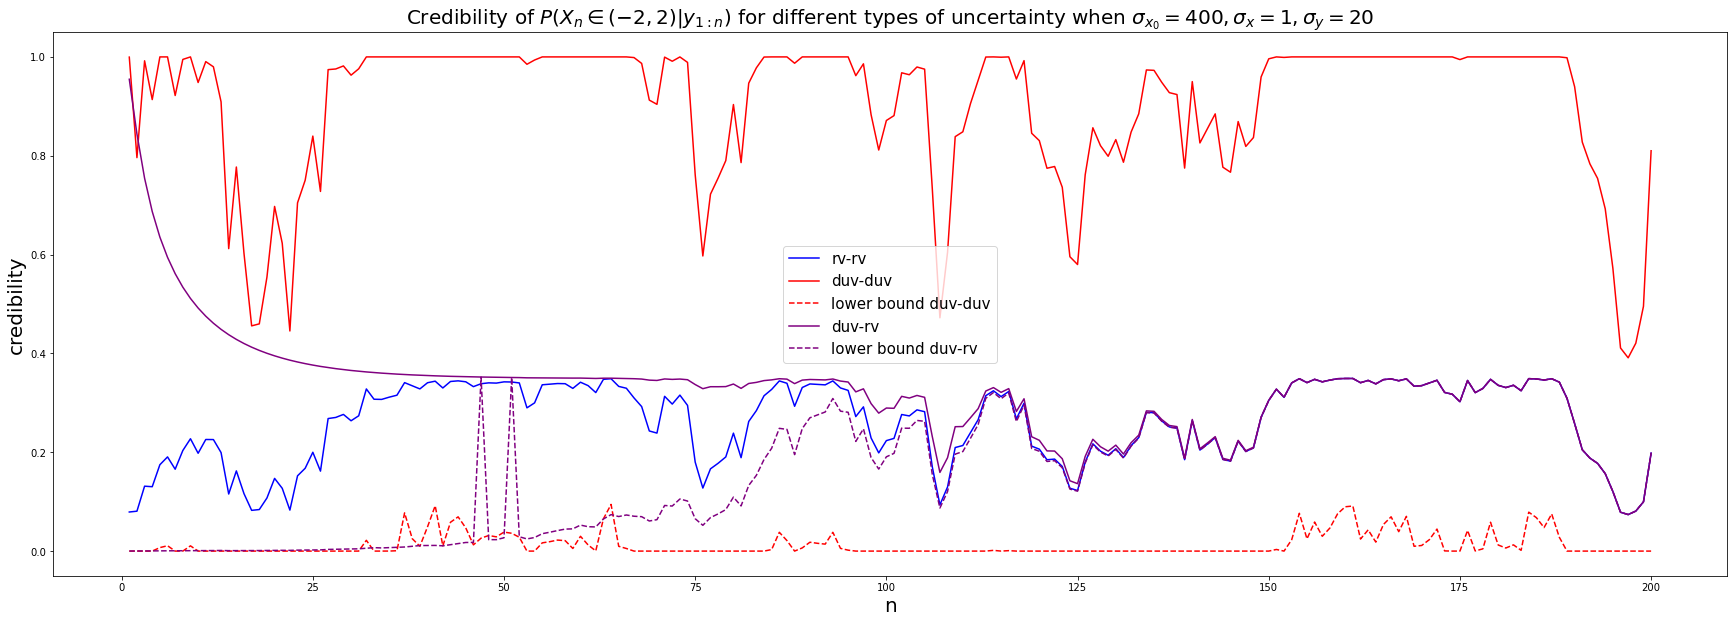

In [361]:
plt.figure(figsize=(30,10))
plt.title("Credibility of $P(X_n \in (-2,2)| y_{1:n})$ for different types of uncertainty when $\sigma_{x_{0}} = 400, \sigma_{x}=1,\sigma_{y}=20$", fontsize = 20)
plt.xlabel('n',fontsize=20)
plt.ylabel('credibility', fontsize=20)
plt.plot(np.arange(start=1, stop=n+1, step=1),cred,linestyle='-',color='blue',label='rv-rv')
plt.plot(np.arange(start=1, stop=n+1, step=1),B,linestyle='-',color='red',label='duv-duv')
plt.plot(np.arange(start=1, stop=n+1, step=1),X,linestyle='--',color='red',label='lower bound duv-duv')
plt.plot(np.arange(start=1, stop=n+1, step=1),D,linestyle='-',color='purple',label='duv-rv')
plt.plot(np.arange(start=1, stop=n+1, step=1),Y,linestyle='--',color='purple',label='lower bound duv-rv')
plt.legend(loc='best',fontsize=15)
plt.show()